In [1]:
import glob
import gzip
import os
import shutil
import sys
import time
from datetime import date
import numpy as np
import pandas as pd
import copy

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def datetime_to_seconds(dates, ref="1900-01-01T00:00:00"):
    """from datetime64 to seconds since 1900-01-01 00:00:00"""
    return ((dates - np.datetime64(ref)) / np.timedelta64(1, "s")).astype(np.int64)

def seconds_to_datetime(seconds, ref="1900-01-01"):
    """from seconds to datetime64"""
    seconds = np.asarray(seconds)
    return pd.to_datetime(seconds, unit="s", origin=ref)

import matplotlib
import matplotlib.pylab as plt
import matplotlib.pyplot as maplt

matplotlib.rcParams.update({"font.size": 20})
matplotlib.rcParams["figure.figsize"] = (20, 10)

In [2]:
import cv2
import numpy as np
from tkinter import Tk, filedialog

from skimage.metrics import structural_similarity

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [3]:
import pytesseract

pytesseract.pytesseract.tesseract_cmd = "/usr/bin/tesseract"

def image_resize(image, width = None, height = None, inter = cv2.INTER_AREA):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # resize the image
    resized = cv2.resize(image, dim, interpolation = inter)

    # return the resized image
    return resized

## CV2

In [4]:
def digitize(file, height_input = False, show_plots = False):  
    matplotlib.rcParams["figure.figsize"] = (4, 3)
    # try:
    %matplotlib inline
    print(file)
    # Load the image
    img = cv2.imread(file)
    # plt.imshow(img)
    # plt.show()
    # plt.close()

    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply a threshold to create a binary image
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    # Find the contours in the binary image
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    # Find the contour with the largest area (i.e., the plot data)
    largest_contour = max(contours, key=cv2.contourArea)

    # Get the bounding box of the contour
    x, y, w, h = cv2.boundingRect(largest_contour)

    # Crop the image to the bounding box
    plot_only = img[y+10:y+h-1, x+1:x+w-1]
    relative_y = y+10
    relative_x = x+1
    relative_y_xaxis =  y+h-1

    # Save the cropped image
    cv2.imwrite('test_plot_only.png', plot_only)

    # Show the cropped image
    # plt.imshow(plot_only)
    # plt.show()

    # Convert the contour to a numpy array and transpose it
    plot_data = largest_contour.squeeze().T

    # Print the plot data
    # print(plot_data)

    

    image = img[ 1272:1285, 20:500]
    # plt.imshow(image)
    # plt.show()
    # plt.close()
    if np.mean(image) == 255:
        print('All white')
        return 0

    image_l = image_resize(image, height = 50)
    gray = cv2.cvtColor(image_l, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (3,3), 0)
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    # Morph open to remove noise and invert image
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)
    inverted = 255 - opening

    data = pytesseract.image_to_string(inverted, lang='eng', config= '--psm 7')



    im = cv2.imread("test_plot_only.png")

    # Define lower and upper limits of our blue
    BlueMax = np.array([128, 255, 255], np.uint8)
    BlueMin = np.array([90, 50, 70], np.uint8)

    # Go to HSV colourspace and get mask of blue pixels
    HSV = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)
    # plt.imshow(HSV)
    # plt.show()
    # plt.close()
    mask = cv2.inRange(HSV, BlueMin, BlueMax)

    # Make all pixels in mask white
    grid = copy.copy(im)
    grid[mask == 0] = [255, 255, 255]
    grid[0:, 0:15] = [255, 255, 255]


    im[mask > 0] = [255, 255, 255]
    im[0:100, 0:15] = [255, 255, 255]
    im[-2:, :] = [255, 255, 255]

    # plt.imshow(im)
    # plt.show()
    # plt.close()
    # plt.imshow(grid)
    # plt.show()
    # plt.close()
    cv2.imwrite("test_grid_only.png", grid)
    cv2.imwrite("test_data_only.png", im)



    # print("Analyzig grid:")

    grid = cv2.imread('test_grid_only.png')
    gray = cv2.cvtColor(grid, cv2.COLOR_BGR2GRAY)

    gray = np.float32(gray)

    dst = cv2.cornerHarris(gray, 5,19,0.07)
    dst = cv2.dilate(dst, None)

    # Get coordinates
    ret, dst = cv2.threshold(dst, 0.1 * dst.max(), 255, 0)
    dst = np.uint8(dst)

    # find centroids
    ret, labels, stats, centroids = cv2.connectedComponentsWithStats(dst)
    # define the criteria to stop and refine the corners
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 
                0.001)
    corners = cv2.cornerSubPix(gray,np.float32(centroids[1:]),(5,5), 
          (-1,-1),criteria)
    # To draw the corners
    for corner in corners:
        grid[int(corner[1]), int(corner[0])] = [0, 0, 255]
    corner_coords = np.asarray(corners, dtype = int)
    corner_coords = corner_coords[corner_coords[:,0] < np.max(corner_coords[:,0]) * 0.9]
    corner_coords = corner_coords[corner_coords[:,1] < np.max(corner_coords[:,1]) * 0.9]
    corner_coords = corner_coords[corner_coords[:,0] > np.max(corner_coords[:,0]) * 0.1]
    corner_coords = corner_coords[corner_coords[:,1] > np.max(corner_coords[:,1]) * 0.1]
    for co in corner_coords:
        grid = cv2.circle(grid, co, radius=4, color=(255, 0, 0), thickness=-1)
    # plt.imshow(grid)
    # plt.show()
    # plt.close()



    # choosing 2 points
    grid = cv2.imread('test_grid_only.png')
    # not on the very outside of the plot:
    maxcoord = np.argmax(np.sum(corner_coords, axis = 1))
    mincoord = np.argmin(np.sum(corner_coords, axis = 1))

    # coords_mean = meancoord
    coords_low = corner_coords[mincoord]
    coords_high = corner_coords[maxcoord]
    grid = cv2.circle(grid, coords_low, radius=4, color=(0, 0, 255), thickness=-1)
    grid = cv2.circle(grid, coords_high, radius=4, color=(0, 0, 255), thickness=-1)

    
    low_y_label = img[relative_y + coords_low[1]-10: relative_y + coords_low[1]+10, relative_x-45:relative_x-1]
    low_y_val = convert_label_y_2(low_y_label, show_input = False, show_plots = show_plots)
    print(low_y_val)
    
    high_y_label = img[relative_y + coords_high[1]-10: relative_y + coords_high[1]+10, relative_x-45:relative_x-1]
    high_y_val = convert_label_y_2(high_y_label, show_input = False, show_plots = show_plots)
    print(high_y_val)

    low_x_label = img[relative_y_xaxis+1 : relative_y_xaxis+20, relative_x+coords_low[0]-20:relative_x+coords_low[0]+30]
    low_x_val = convert_label(low_x_label, show_input = False, show_plots = show_plots)
    print(low_x_val)    
    
    high_x_label = img[relative_y_xaxis+1 : relative_y_xaxis+20, relative_x+coords_high[0]-30:relative_x+coords_high[0]+30]
    high_x_val = convert_label(high_x_label, show_input = False, show_plots = show_plots)
    print(high_x_val)
    
    print()
    
    if low_x_val > 0 and low_x_val > high_x_val:
        low_x_val = str(float(low_x_val) * -1)
        print('changed to: ', low_x_val)


    
    # converting axis texts to data:
    # print('low: ',coords_low, low_x_val, low_y_val)
    # print('high: ',coords_high, high_x_val, high_y_val)
    xa_p = [coords_low[0], coords_high[0]]
    xa_v = [273.15+low_x_val, 273.15+high_x_val]
    ya_p = [coords_low[1], coords_high[1]]
    ya_v = [low_y_val, high_y_val]
    # display(xa_p)
    # display(xa_v)
    # display(ya_p)
    # display(ya_v)
    # print()

    
    # calculation of axis functions
    # x-axis
    x1 = xa_p[0]
    a = xa_v[0]
    x2 = xa_p[1]
    b = xa_v[1]

    m_T = (b - a) / (x2 - x1)
    c_T = a - m_T * x1
    def T(x):
        return m_T * x + c_T

    # y-axis
    if height_input:
        y1 = ya_p[0]
        ap = ya_v[0]
        y2 = ya_p[1]
        bp = ya_v[1]
    else: 
        y1 = ya_p[0]
        ap = np.log(ya_v[0])
        y2 = ya_p[1]
        bp = np.log(ya_v[1])

    m = (bp - ap) / (y2 - y1)
    c = ap - m * y1
    def P(x):
        return m * x + c

    
    # selection of data points via contour of graph:
    graph = cv2.imread('test_data_only.png')
    edge = cv2.Canny(graph, 30, 200) 
    ans = []
    for y in range(0, edge.shape[0]):
        for x in range(0, edge.shape[1]):
            if edge[y, x] != 0:
                ans = ans + [[x, y]]
    ans = np.array(ans)

    # print(ans.shape)
    # print(ans[0:10, :])

    for co in ans[:]:
        image = cv2.circle(graph, co, radius=4, color=(255, 0, 0), thickness=-1)
    # plt.imshow(image)
    # plt.show()
    # plt.close()


    unique_steps = []
    for i in range(np.min(ans[:,1]), np.max(ans[:,1])+1):
        step = ans[ans[:,1] == i]
        if len(step) > 1:
            mean_step = (np.mean(step, axis=0))
            unique_steps.append([int(mean_step[0]), int(mean_step[1])])
        elif len(step) == 1:
            unique_steps.append([int(step[0][0]), (step[0][1])])
    unique_steps


    # points to data with functions:
    out = {}
    # out['press'] = np.exp(P(ans[0::20][:,1]))
    # out['temp'] = (T(ans[0::20][:,0]))
    if height_input:
        out['press'] = P(np.array(unique_steps)[:,1])
    else:
        out['press'] = np.exp(P(np.array(unique_steps)[:,1]))
    out['temp'] = T(np.array(unique_steps)[:,0])
    df = pd.DataFrame.from_dict(out)
    df = df.sort_values('press')
    if height_input:
        df.to_csv('./out_height_zoomed/' + file.split('sc_')[-1].split('.png')[0]+'.csv')
    else:
        df.to_csv('./out_data/' + file.split('sc_')[-1].split('.png')[0]+'.csv')
    # except Exception as e:
    #     print(str(e))
    #     return 0
    return df

In [5]:
def convert_label(label, show_input = False, show_plots = True):
    out = []
    set_psm =  '--psm 6 --oem 3 -c tessedit_char_whitelist=0123456789-,._C preserve_interword_spaces=1' #'--psm 6' # 'outputbase digits'

    if show_input:
        plt.imshow(label)
        plt.show()
        plt.close()
        
    # label = cv2.imread('./large_40.png')
    label = image_resize(label, height=100, inter=cv2.INTER_CUBIC)


    gray = cv2.cvtColor(label, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5,5), 0)
    thresh_val = 50
    thresh = cv2.threshold(blur, thresh_val, thresh_val, cv2.THRESH_BINARY)[1]
    edges = cv2.Canny(thresh,100,200)
    vertical_sum = np.sum(edges, axis=0)
    vertical_sum = vertical_sum != 0
    changes = np.logical_xor(vertical_sum[1:], vertical_sum[:-1])
    change_pts = np.nonzero(changes)[0]
    if show_plots:
        print('character detection')
        plt.imshow(thresh)
        for change in change_pts:
            plt.axvline(change+1)
        plt.show()
        plt.close()

    for i in range(len(change_pts)-1):
        start = change_pts[i]
        end =  change_pts[i+1]
        if start != end and end-start > 10:
            cut = label[:, start:end]
            cut = cv2.copyMakeBorder(
                     cut, 
                     1, 
                     1, 
                     20, 
                     20, 
                     cv2.BORDER_CONSTANT, 
                     value= [175,175,175]
                  )
            # plt.imshow(cut)
            # plt.show()
            # plt.close()

            gray = cv2.cvtColor(cut, cv2.COLOR_BGR2GRAY)
            blur = cv2.GaussianBlur(gray, (5,5), 0)
            thresh = cv2.threshold(blur, 255, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

            # Morph open to remove noise and invert image
            kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
            opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)
            inverted = 255 - opening
            if show_plots:
                plt.imshow(inverted)
                plt.show()
                plt.close()
    #         inverted = image_resize(inverted, height = 50)
            out_val = pytesseract.image_to_string(inverted, lang='eng', config= set_psm)
            if out_val == '\x0c':
                out.append('-')
            else:
                out.append( out_val.split('\n\x0c')[0])
    return_str = ''.join(out)
    minus_signs = [pos for pos, char in enumerate(return_str) if char == '-']
    if (minus_signs != [0]) and (minus_signs != []):
        match_found = False
        for id_img in glob.glob('./identified_images/*.png'):
            # Load images
            to_compare_to = cv2.imread(id_img)
            if np.all(label == to_compare_to):
                match_found = True
                if '_' in id_img.split('./identified_images/')[-1]:
                    return_str = id_img.split('./identified_images/')[-1].split('_')[0]
                else:
                    return_str = id_img.split('.png')[0].split('./identified_images/')[-1]
                break

        if match_found:
            return float(return_str)
        else:
            plt.imshow(label)
            plt.show()
            plt.close()
            print(minus_signs)
            return_str = input('please help me read this lable: ')
            out_nr = 0
            while True:
                out_name = './identified_images/'+return_str+'_'+str(out_nr)+'.png'
                out_nr += 1
                if not os.path.isdir(out_name):
                    break
            
            cv2.imwrite(out_name, label)
    
    return float(return_str)

    
# def convert_label_y(label, show_input = False):
#     rs_h = 50
#     set_psm =  '--psm 6 --oem 3 -c tessedit_char_whitelist=0123456789-,._C preserve_interword_spaces=1'
#     if show_input:
#         plt.imshow(label)
#         plt.show()
#         plt.close()
    
#     label = image_resize(label, height = rs_h, inter=cv2.INTER_CUBIC)

#     gray = cv2.cvtColor(label, cv2.COLOR_BGR2GRAY)
#     blur = cv2.GaussianBlur(gray, (3,3), 0)
#     thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

#     # Morph open to remove noise and invert image
#     kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
#     opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)
#     inverted = 255 - opening

#     val = pytesseract.image_to_string(inverted, lang='eng', config= set_psm)
#     val = "".join([x for x in val.replace('.', '').split('\n\x0c')[0]])
#     if len(val) < 3:
#         val = float(val)*1000
#     else:
#         val = float(val)
#     return val

def convert_label_y_2(label, show_input = False, show_plots = True):
    out = []
    set_psm =  '--psm 6 --oem 3 -c tessedit_char_whitelist=0123456789-,._C preserve_interword_spaces=1' #'--psm 6' # 'outputbase digits'

    if show_input:
        plt.imshow(label)
        plt.show()
        plt.close()
        
    # label = cv2.imread('./large_40.png')
    label = image_resize(label, height=100, inter=cv2.INTER_CUBIC)


    gray = cv2.cvtColor(label, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5,5), 0)
    thresh_val = 50
    thresh = cv2.threshold(blur, thresh_val, thresh_val, cv2.THRESH_BINARY)[1]
    edges = cv2.Canny(thresh,100,200)
    vertical_sum = np.sum(edges, axis=0)
    vertical_sum = vertical_sum != 0
    changes = np.logical_xor(vertical_sum[1:], vertical_sum[:-1])
    change_pts = np.nonzero(changes)[0]
    if show_plots:
        print('character detection')
        plt.imshow(thresh)
        for change in change_pts:
            plt.axvline(change+1)
        plt.show()
        plt.close()

    for i in range(len(change_pts)-1):
        start = change_pts[i]
        end =  change_pts[i+1]
        if start != end and end-start > 10:
            cut = label[:, start:end]
            cut = cv2.copyMakeBorder(
                     cut, 
                     1, 
                     1, 
                     20, 
                     20, 
                     cv2.BORDER_CONSTANT, 
                     value= [175,175,175]
                  )
            # plt.imshow(cut)
            # plt.show()
            # plt.close()

            gray = cv2.cvtColor(cut, cv2.COLOR_BGR2GRAY)
            blur = cv2.GaussianBlur(gray, (5,5), 0)
            thresh = cv2.threshold(blur, 255, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

            # Morph open to remove noise and invert image
            kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
            opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)
            inverted = 255 - opening
            if show_plots:
                plt.imshow(inverted)
                plt.show()
                plt.close()
    #         inverted = image_resize(inverted, height = 50)
            out_val = pytesseract.image_to_string(inverted, lang='eng', config= set_psm)
            if out_val == '\x0c':
                out.append('')
            else:
                out.append( out_val.split('\n\x0c')[0])
    return_str = ''.join(out)
    minus_signs = [pos for pos, char in enumerate(return_str) if not np.isin(char, ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])]
    if (minus_signs != [0]) and (minus_signs != []):
        for id_img in glob.glob('./identified_images/*.png'):
            # Load images
            to_compare_to = cv2.imread(id_img)

            # Compute SSIM between the two images
            (score, diff) = structural_similarity(label, to_compare_to, full=True)
            print("Image Similarity: {:.4f}%".format(score * 100))
        plt.imshow(label)
        plt.show()
        plt.close()
        print(minus_signs)
        return_str = input('please help me read this lable: ')
        out_nr = 0
        while True:
            out_name = './identified_images/'+return_str+'_'+str(out_nr)+'.png'
            out_nr += 1
            if not os.path.isdir(out_name):
                break

        cv2.imwrite(out_name, label)

    if len(return_str) < 3:
        val = float(return_str)*1000
    else:
        val = float(return_str)
    return val


In [95]:
# for j in range(1,11):
# for j in range(4,11,1):
j = 10
for i in glob.glob('./height_data_zoomed/sc_Vaisala_'+str(j)+'_*_.png'): # MKII_'+str(j)+'
    df = digitize(i, height_input = True, show_plots=False)

./height_data_zoomed/sc_Vaisala_10_6_.png
4500.0
1000.0
2.0


/tmp/ipykernel_13101/692237395.py:74: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if np.all(label == to_compare_to):


18.0

./height_data_zoomed/sc_Vaisala_10_3_.png
19000.0
15000.0
-79.0
-66.0

./height_data_zoomed/sc_Vaisala_10_1_.png
29000.0
25000.0
-55.0
-48.0

./height_data_zoomed/sc_Vaisala_10_0_.png
32500.0
29000.0
-46.0
-37.0

./height_data_zoomed/sc_Vaisala_10_5_.png
9500.0
5500.0
-28.0
0.0

./height_data_zoomed/sc_Vaisala_10_4_.png
14000.0
10000.0
-68.0
-30.0

./height_data_zoomed/sc_Vaisala_10_2_.png
24000.0
20000.0
-72.0
-58.0



In [ ]:
import cv2
import numpy as np

img_rgb = cv2.imread('./identified_images/18.png')
template = cv2.imread('mario_coin.png')
w, h = template.shape[:-1]

res = cv2.matchTemplate(img_rgb, template, cv2.TM_CCOEFF_NORMED)
threshold = .8
loc = np.where(res >= threshold)
for pt in zip(*loc[::-1]):  # Switch columns and rows
    cv2.rectangle(img_rgb, pt, (pt[0] + w, pt[1] + h), (0, 0, 255), 2)

cv2.imwrite('result.png', img_rgb)

./height_data_zoomed/sc_Vaisala_6_6_.png
4500.0
1000.0
character detection


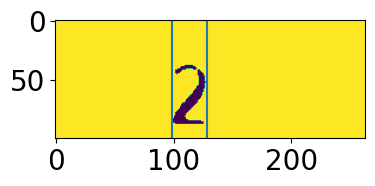

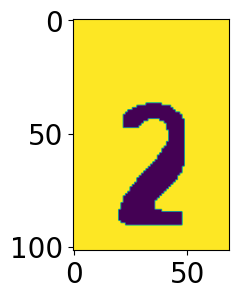

2.0
character detection


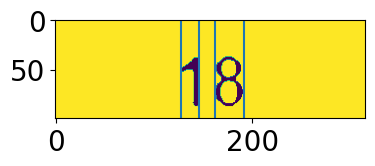

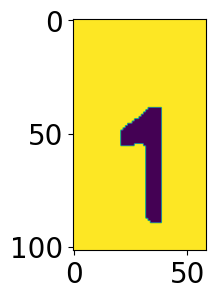

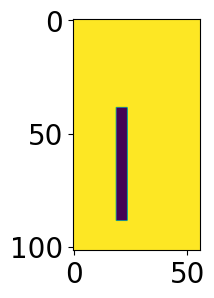

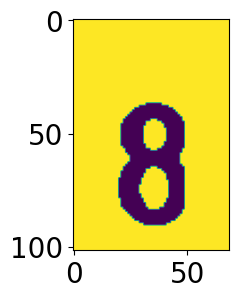

18.0



press        temp
1125   424.598269  296.409740
1124   428.924598  296.461688
1123   433.250927  296.422727
1122   437.577256  296.487662
1121   446.229913  296.435714
...           ...         ...
4     5278.739184  272.695455
3     5283.065513  272.695455
2     5287.391842  272.630519
1     5291.718171  272.617532
0     5296.044499  272.591558

[1126 rows x 2 columns]

In [39]:
digitize('./height_data_zoomed/sc_Vaisala_6_6_.png', height_input = True)

In [6]:
vais_df = pd.read_csv('./vaisala_ascents.csv')
asc_list = list(vais_df.date_time.drop_duplicates())
asc_list

['07-02-2005 10:01:53.551',
 '07-02-2005 14:57:50.481',
 '07-02-2005 19:31:41.965',
 '08-02-2005 05:13:16.722',
 '08-02-2005 10:00:56.553',
 '08-02-2005 15:03:03.289',
 '08-02-2005 19:33:03.372',
 '09-02-2005 05:12:00.618',
 '09-02-2005 10:05:05.418',
 '09-02-2005 14:59:48.197',
 '09-02-2005 19:17:51.222',
 '10-02-2005 05:02:13.432',
 '10-02-2005 09:58:41.940',
 '10-02-2005 14:57:54.734',
 '10-02-2005 19:00:19.242',
 '11-02-2005 05:02:45.185',
 '11-02-2005 15:05:21.407',
 '11-02-2005 18:31:58.407',
 '12-02-2005 15:00:05.867',
 '12-02-2005 18:36:55.168',
 '14-02-2005 05:06:57.494',
 '14-02-2005 10:08:04.684',
 '14-02-2005 15:00:54.504',
 '14-02-2005 18:00:36.448',
 '15-02-2005 05:16:46.851',
 '15-02-2005 10:03:06.727',
 '15-02-2005 15:01:34.429',
 '15-02-2005 18:11:25.926',
 '16-02-2005 05:11:08.125',
 '16-02-2005 10:03:34.821',
 '17-02-2005 10:15:24.825',
 '17-02-2005 14:59:11.401',
 '17-02-2005 18:03:18.602',
 '18-02-2005 05:13:26.446',
 '18-02-2005 10:07:00.508',
 '18-02-2005 14:59:1

In [7]:
def find_nearest(array, value, array_matching = np.nan):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    if np.isnan(array_matching).all():
        return array[idx]
    else:
        return array_matching[idx]

# Fitting for minmal delta z

In [62]:
from scipy.optimize import minimize_scalar

In [67]:
def f(o, df, vais_df):
    i = o/100000
    diffs = []
    for lev_p, lev_t in zip(df.press + i*df.press, df.temp):
        diffs.append(lev_t - find_nearest(np.array(vais_df.height), lev_p, np.array(vais_df.temperature)))
    return np.sum(np.abs(diffs))

In [200]:
height_list = {}
parameter_list = {}
for i in range(len(ascs[:10])):
    to_merge = []
    for j in glob.glob('./out_height_zoomed/Vaisala_'+str(i+1)+'_*_.csv'):
        to_merge.append(pd.read_csv(j, usecols=['press', 'temp']))
    whole_df = pd.concat(to_merge, join='outer', ).sort_values(by='press', ascending=True)

    ascs = asc_list[i]
    vais_df = pd.read_csv('./vaisala_ascents.csv')
    vais_df = vais_df[vais_df.date_time == ascs]
    vais_df = vais_df[vais_df.height > 0]
    vais_df.temperature = vais_df.temperature + 273.15

    
    parameter_list[i] = []
    for height in range(0,35):
        parameter_list[i].append(minimize_scalar(f, 200, args=(whole_df[np.logical_and(whole_df.press >= height * 1000 , whole_df.press < (height+1) * 1000)], 
                                                            vais_df[np.logical_and(vais_df.height >= height * 1000 , vais_df.height < (height+1) * 1000)]),
                                              bounds=[0,500]).x)
height_list[i] = []
for height in range(0,35):
    height_list[i].append(height*1000)

In [201]:
mean_parameter_list = np.mean(list(parameter_list.values()), axis=0)

In [202]:
mean_parameter_list

array([101.61457161,  79.99679355,  38.29446924,  43.35908062,
        31.2057778 ,  36.31299413,  32.21877551,  33.05901863,
        37.31883535,  32.72601053,  24.89086315,  25.75750685,
        29.94627471,  40.45710678,  47.52010857,  34.04632798,
        38.38053664,  55.14013017,  77.84798791,  91.39321648,
        99.61465423, 106.02247236, 127.6964826 , 151.78874333,
       161.54435229, 181.95407945, 197.81948036, 225.14114564,
       284.83333306, 313.01586691, 352.66327891, 369.22626412,
       389.20400709, 402.63259764, 430.62884636])

In [203]:
parameter_list = np.array(mean_parameter_list)/100000
height_list = height_list[list(height_list.keys())[0]]
parameter_fit = np.polyfit(height_list, parameter_list, deg=3)
parameter_function = np.poly1d(parameter_fit)

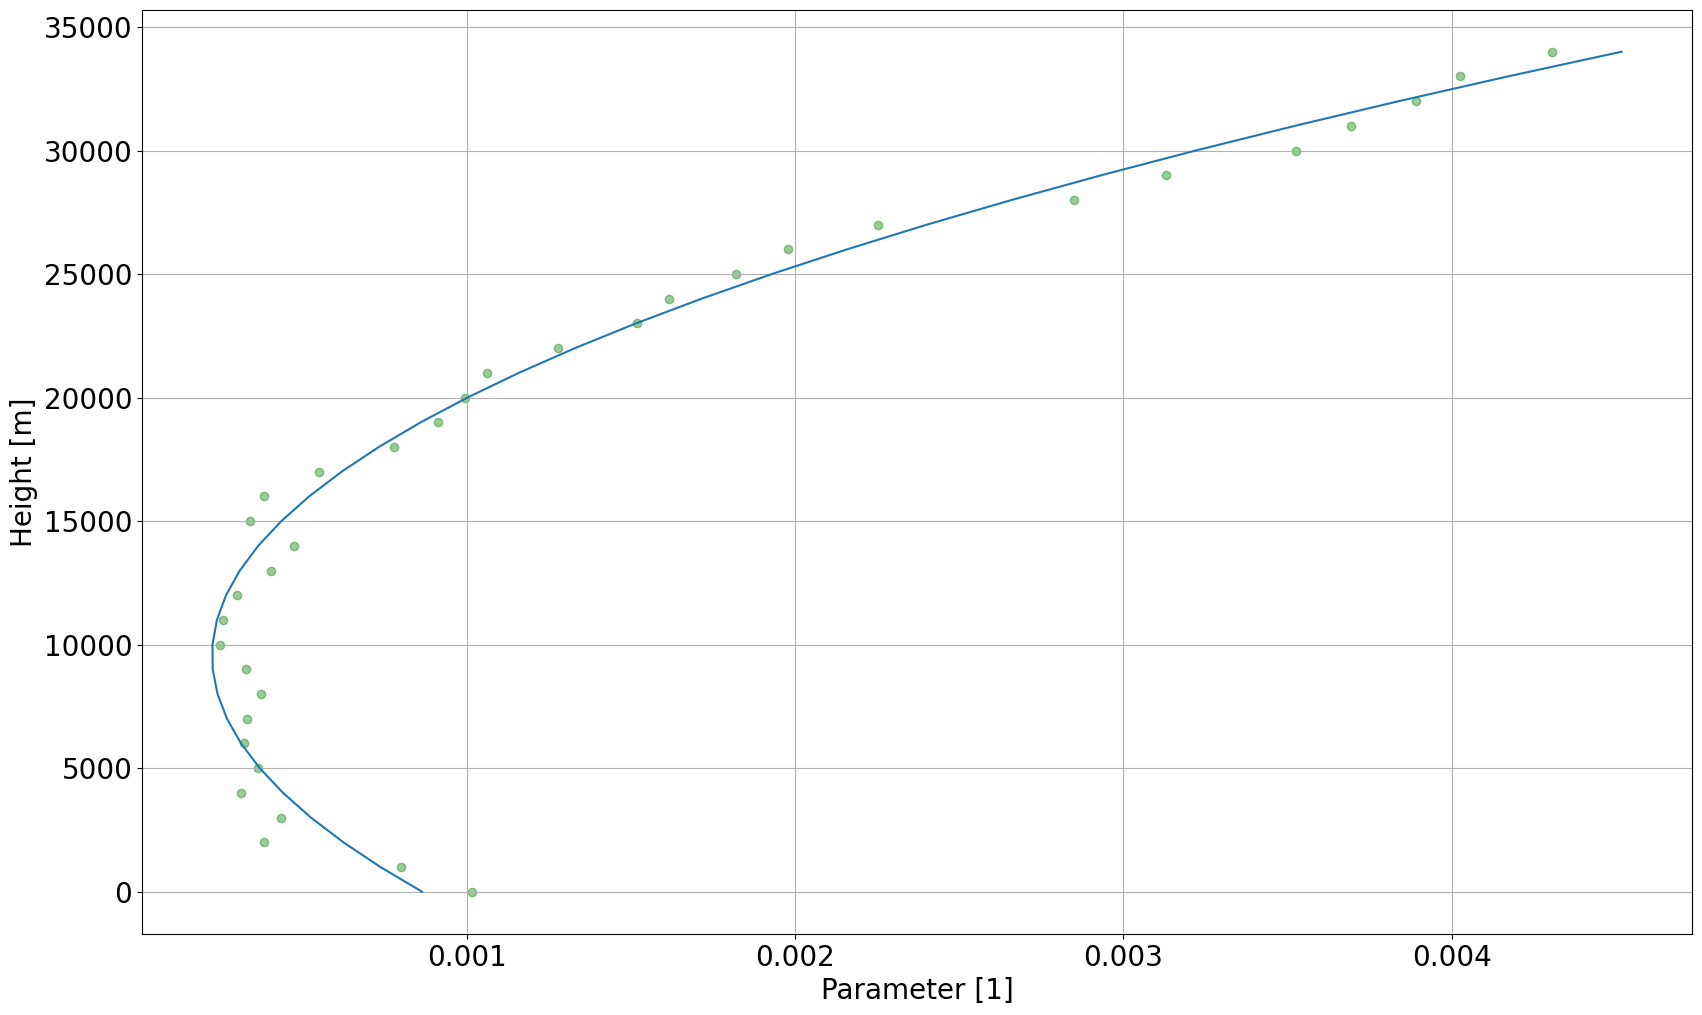

In [204]:
plt.plot(parameter_function(height_list), height_list, label='parameter function')#, alpha = 0.4, linewidth = 6)
ax = plt.gca()
ax.grid()
ax.set_xlabel('Parameter [1]')
ax.set_ylabel('Height [m]')
ax.scatter(parameter_list, height_list , color='green', alpha = 0.4, label='minimized parameters')#, alpha = 0.4, linewidth = 6)

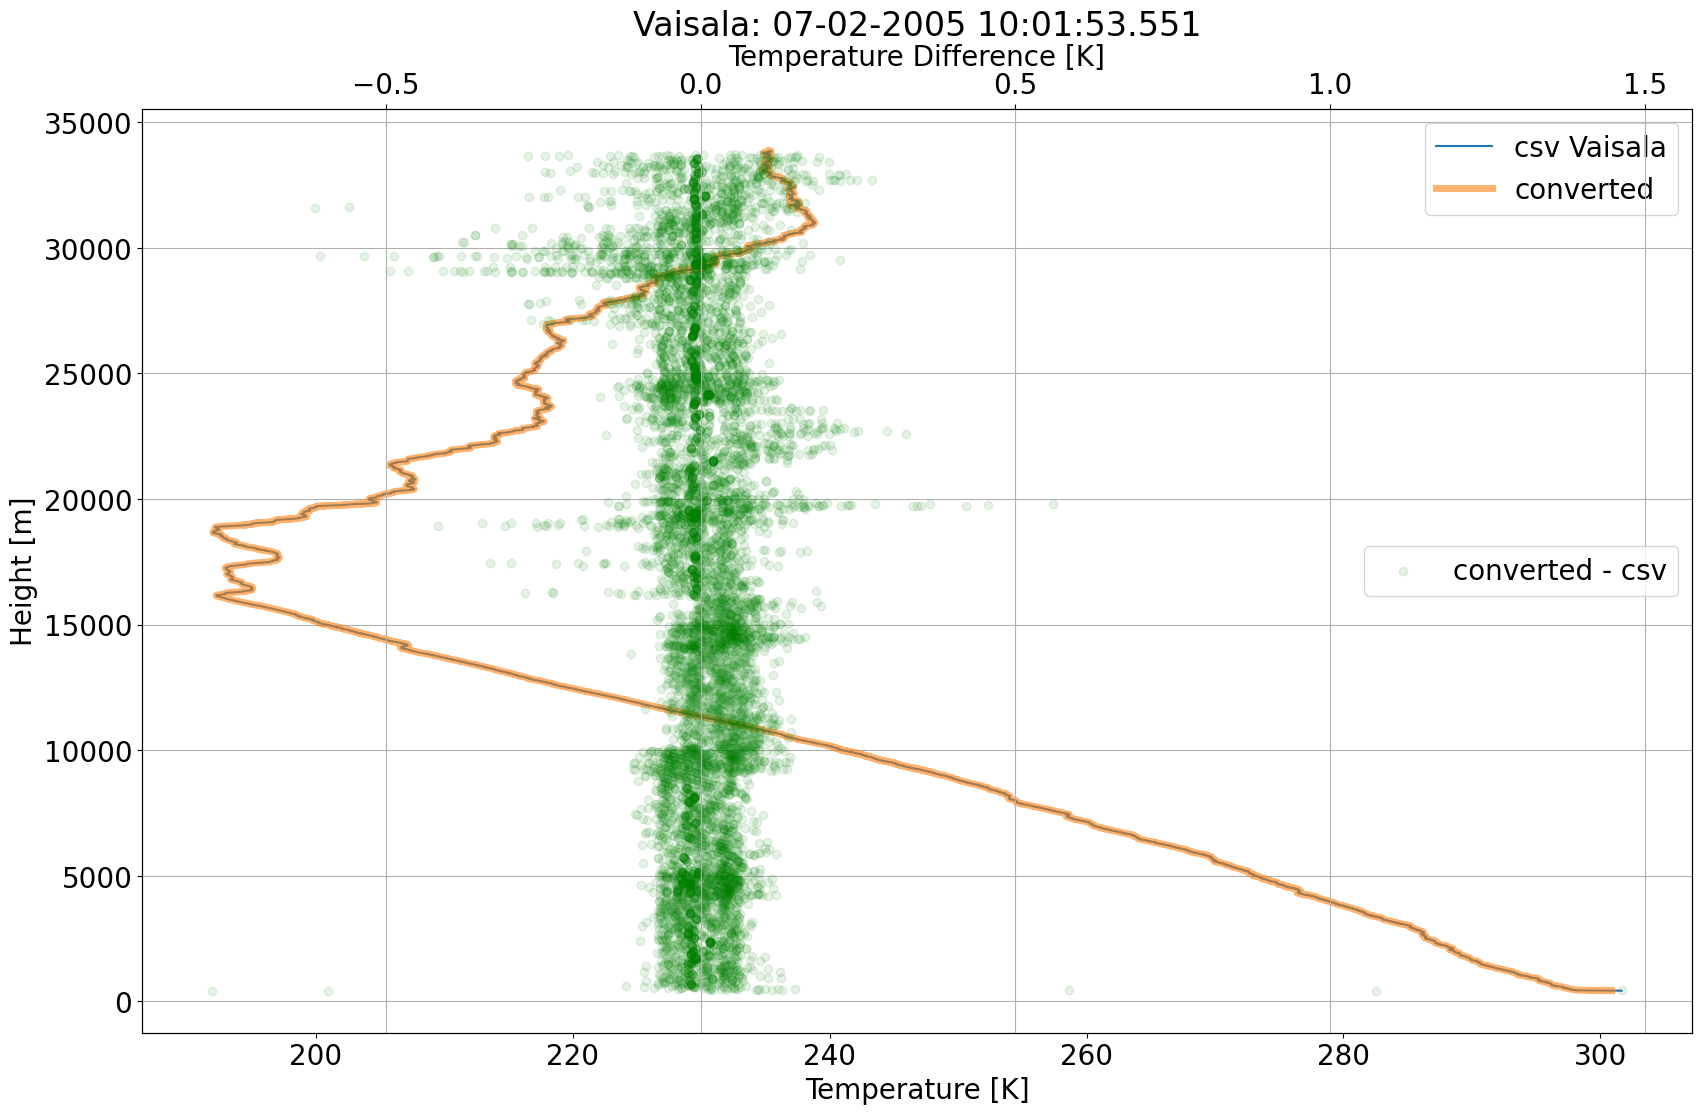

0.0021184587449199874


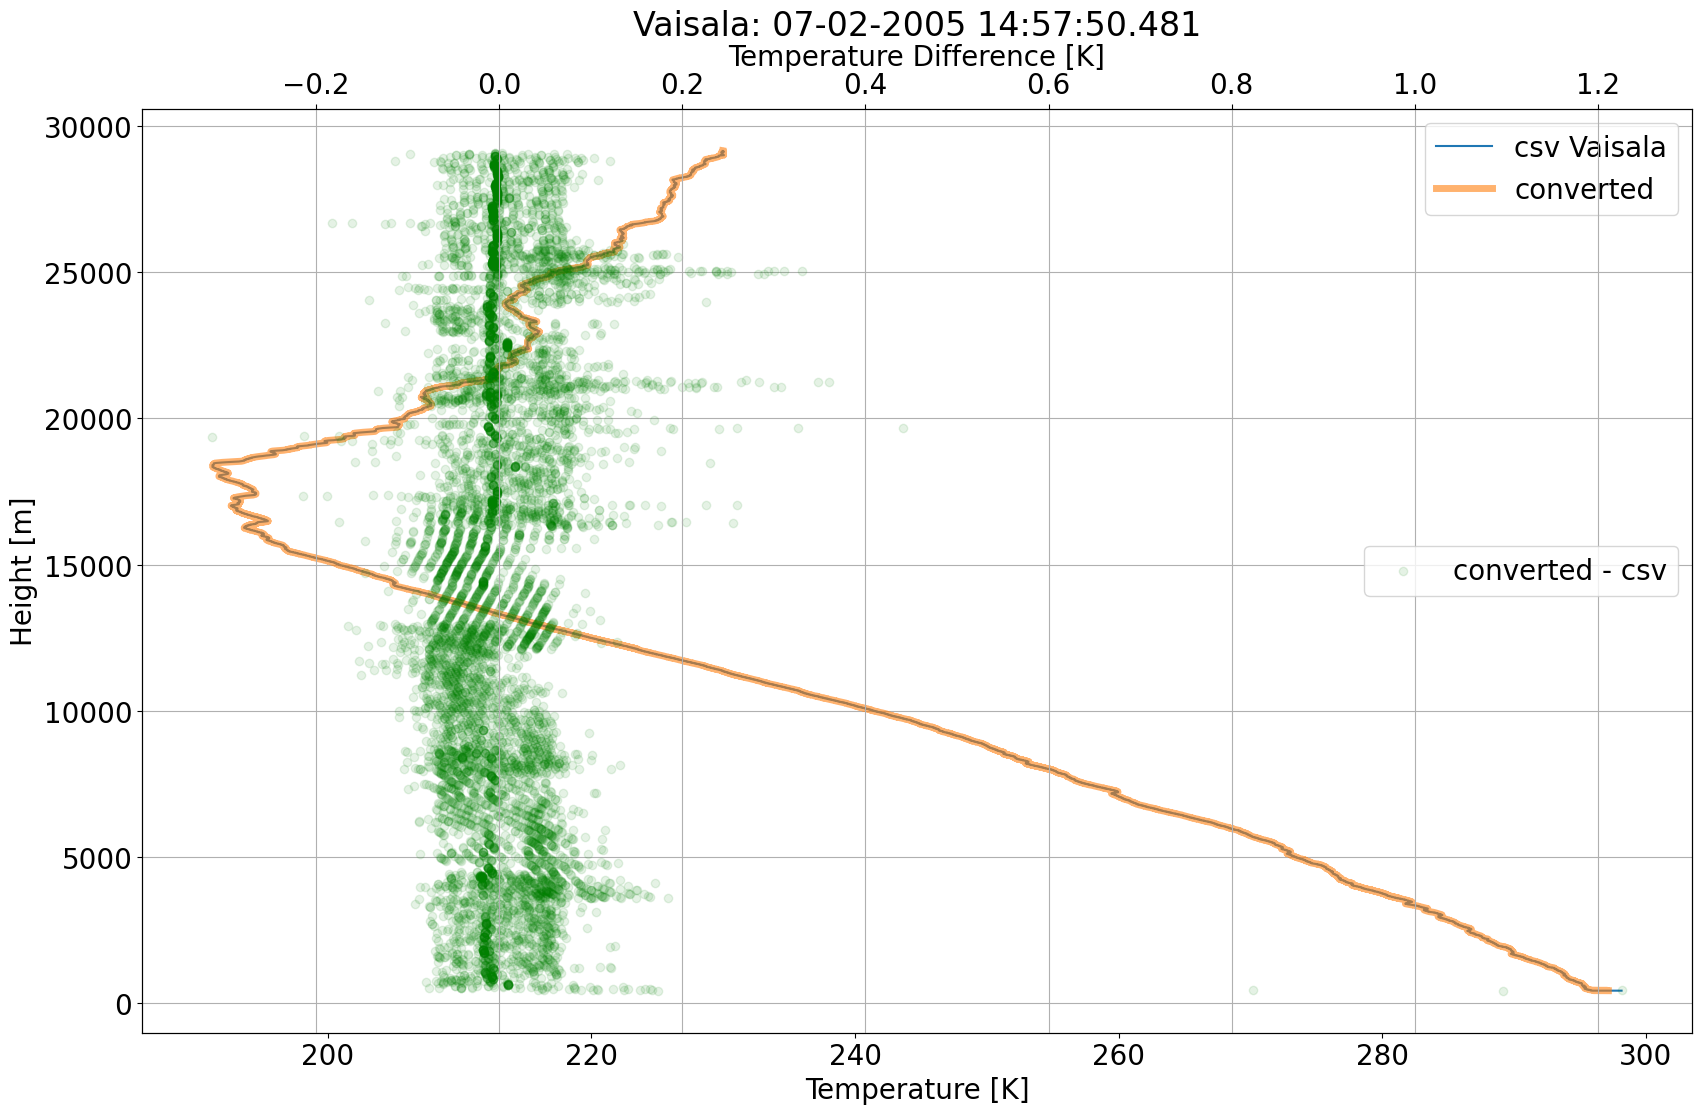

0.003356179558100991


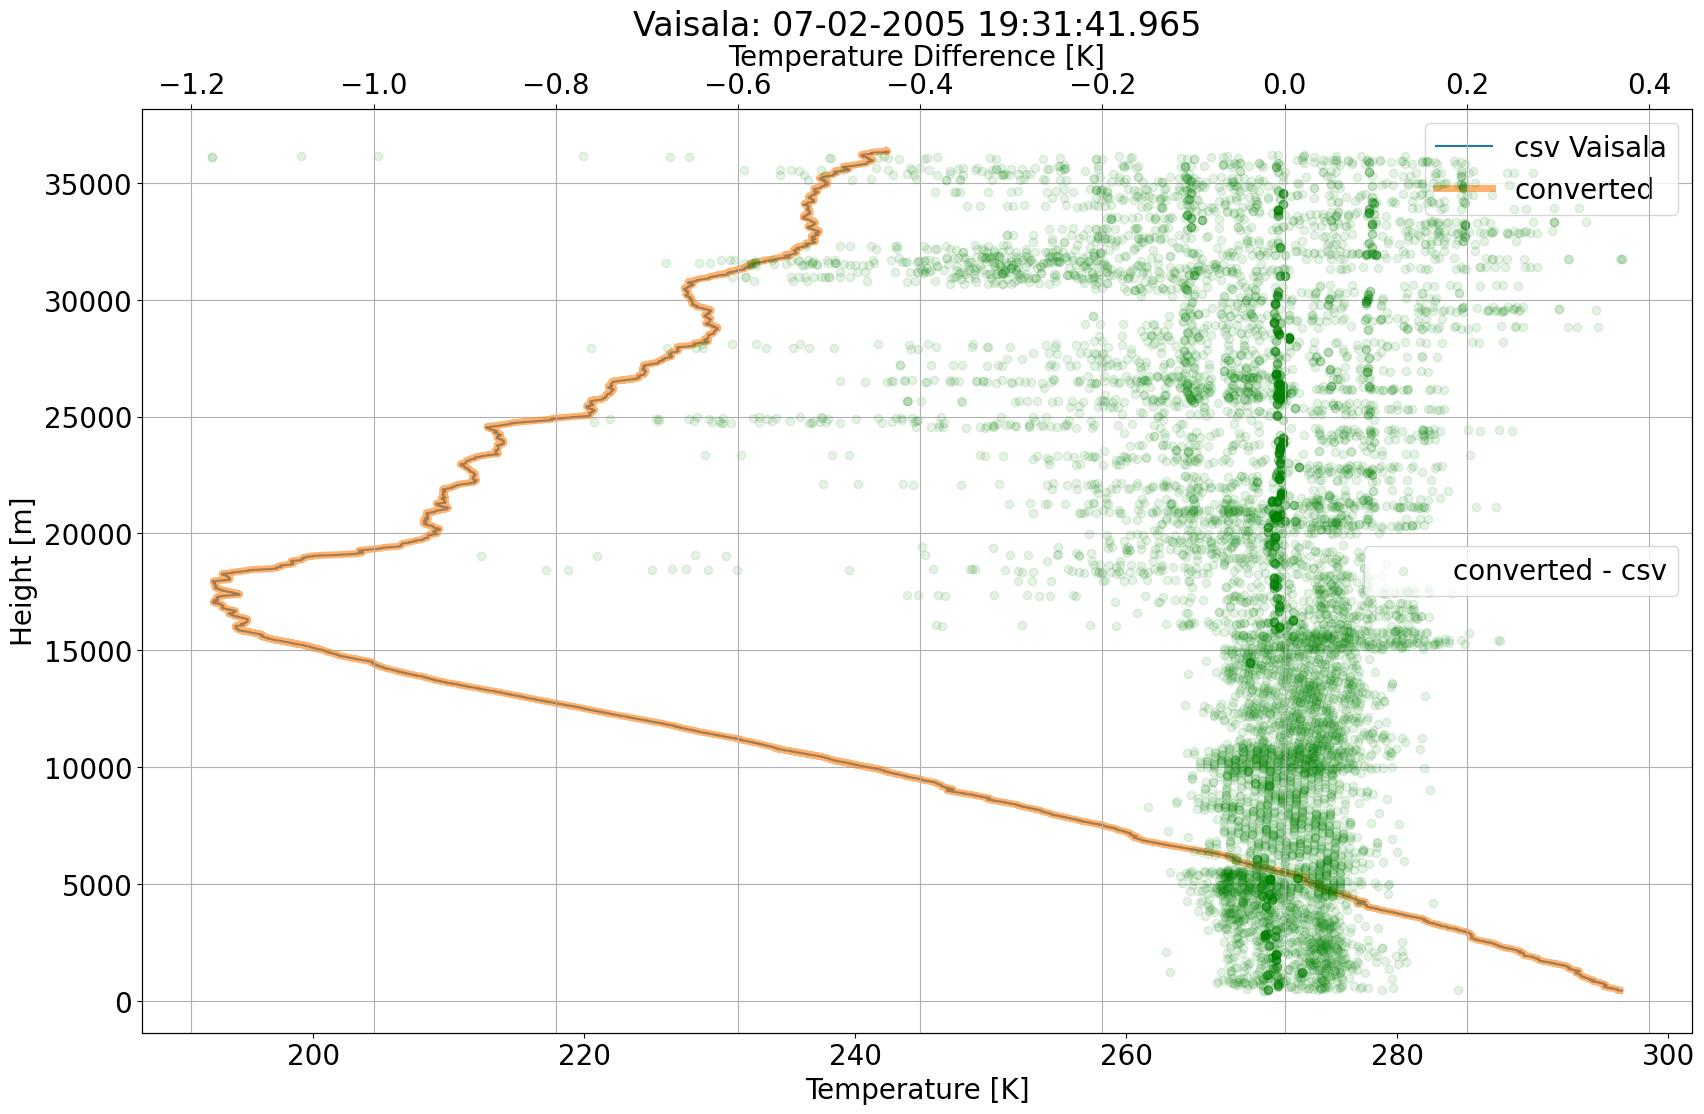

-0.031274731484823626


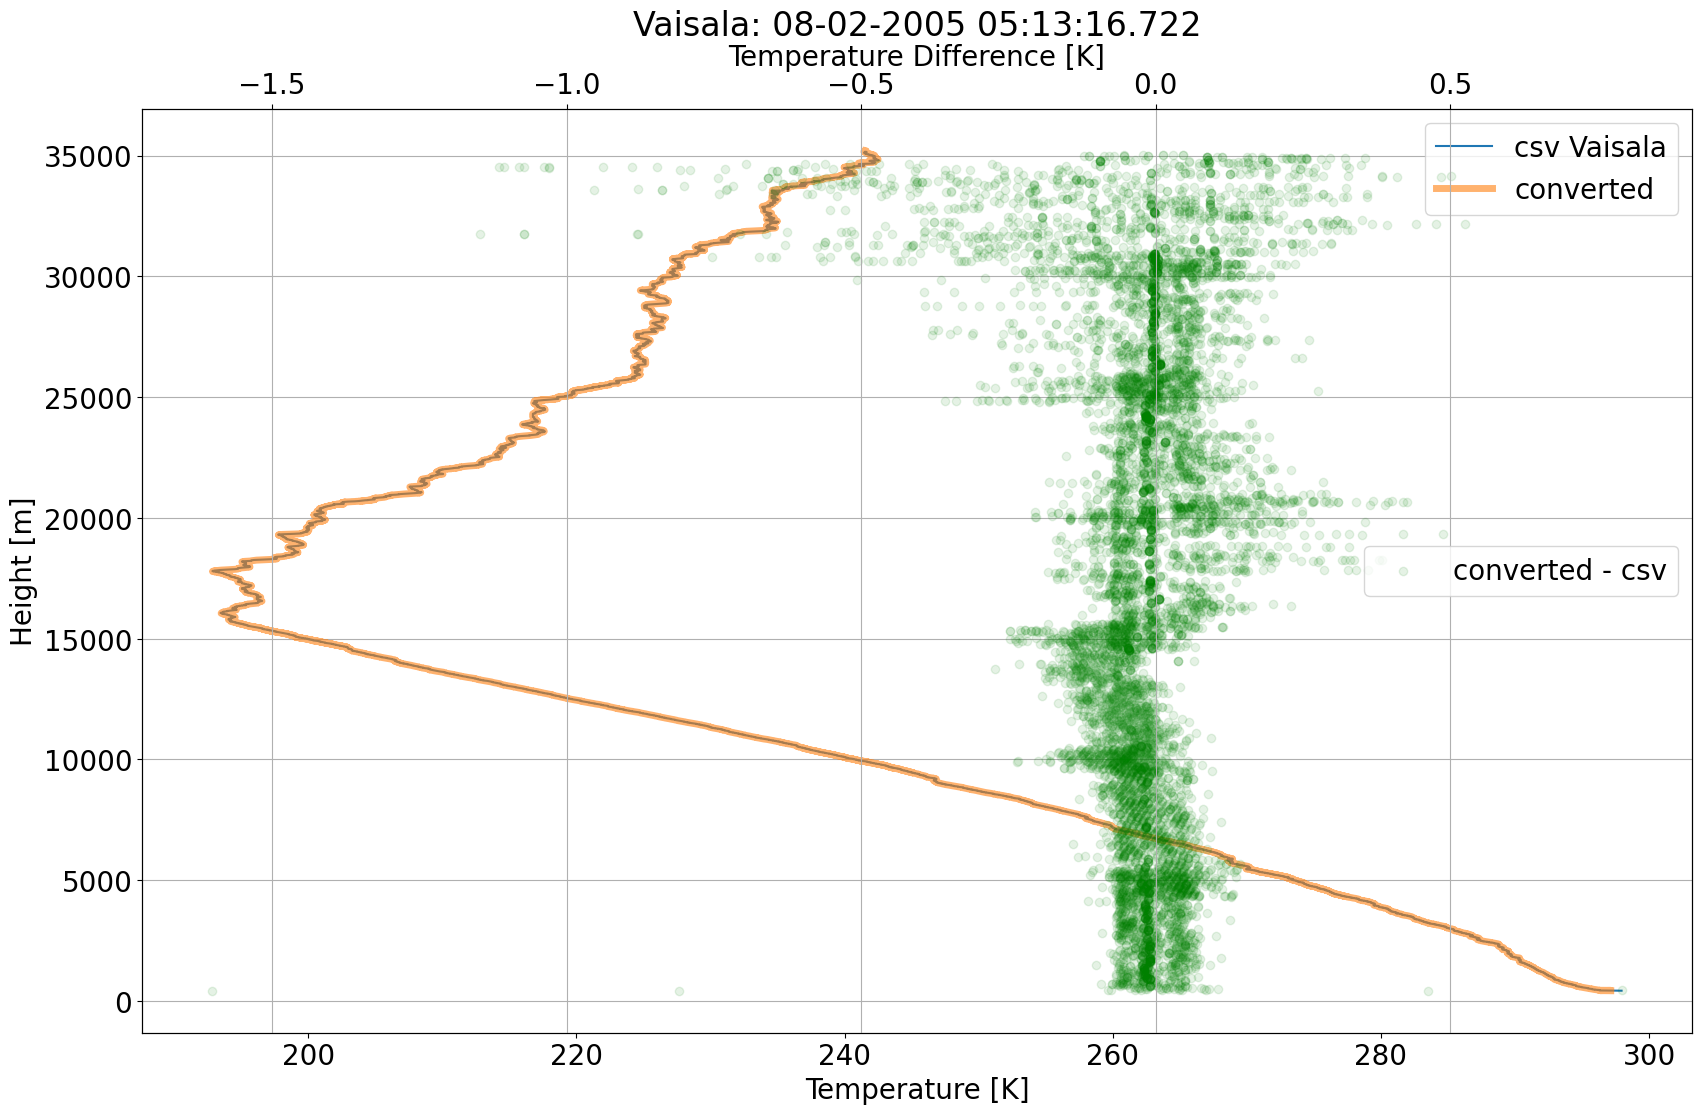

-0.022887026064206766


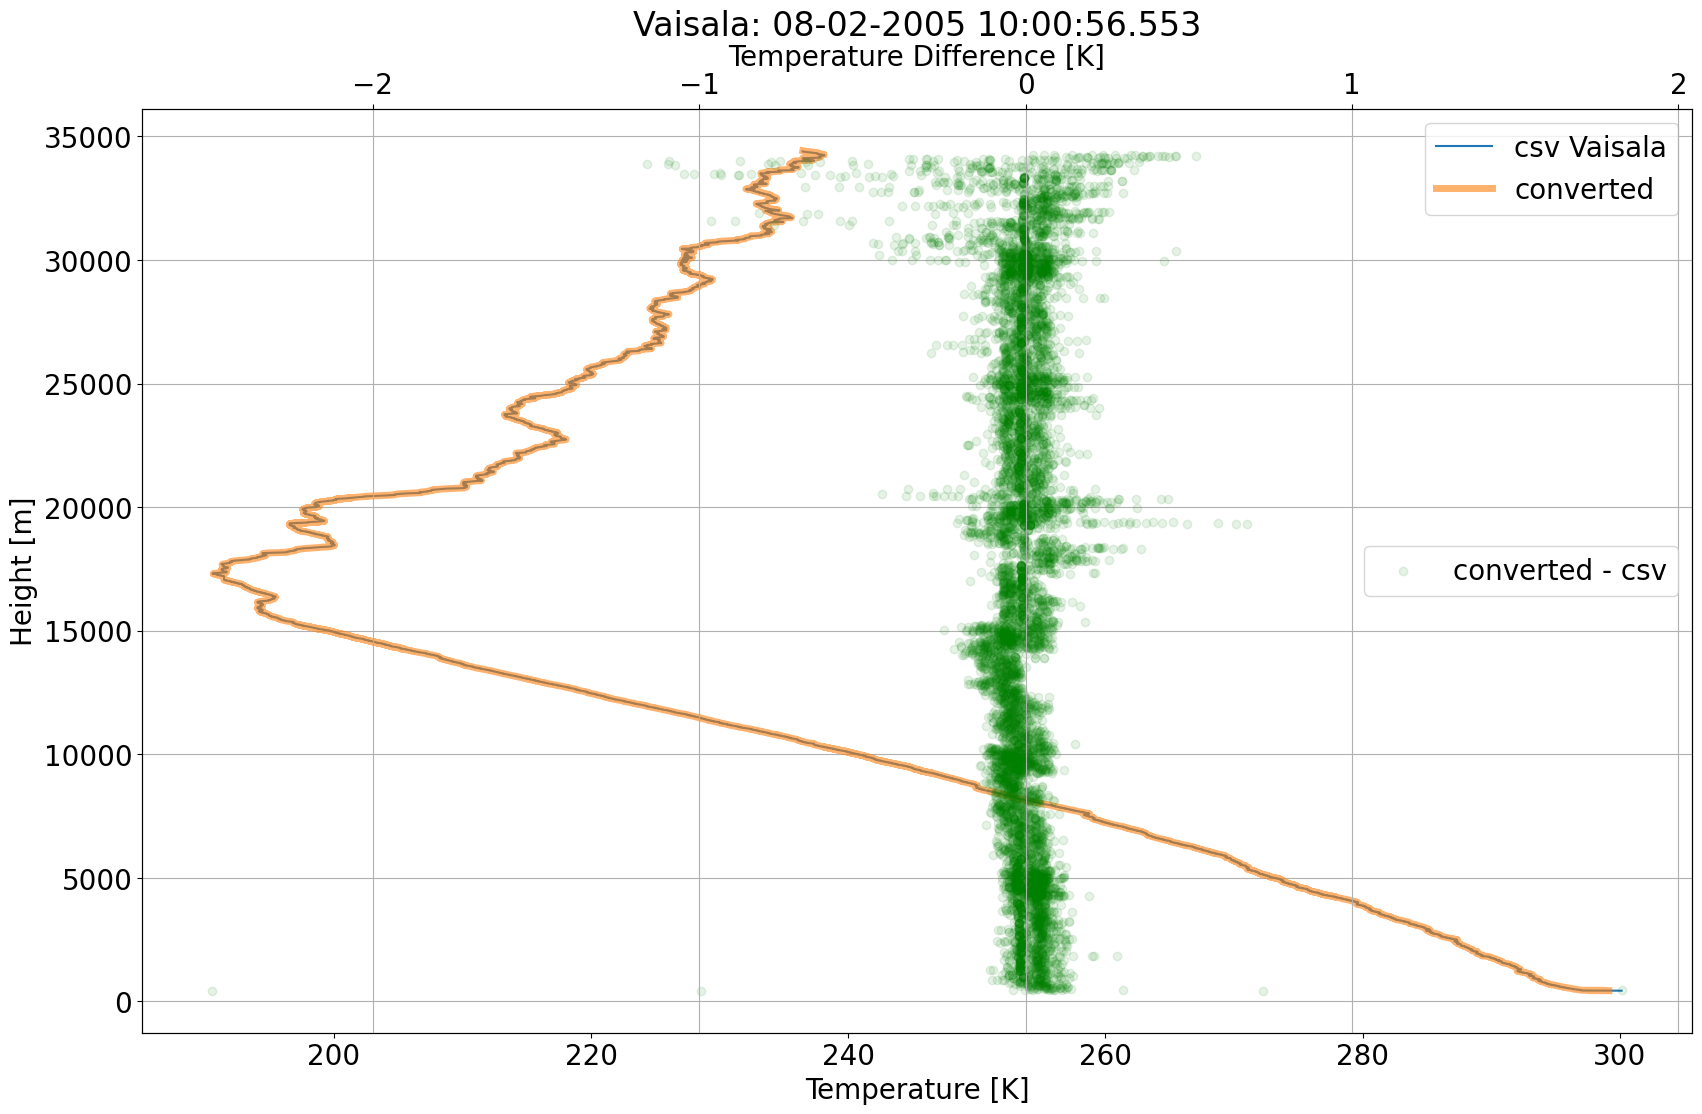

-0.009407163439365249


In [205]:
matplotlib.rcParams["figure.figsize"] = (20, 12)
ascs = asc_list[:] #['07-02-2005 10:01:53.551', '07-02-2005 14:57:50.481', '07-02-2005 19:31:41.965']
o = 315
for i in range(len(ascs[:5])):
    to_merge = []
    for j in glob.glob('./out_height_zoomed/Vaisala_'+str(i+1)+'_*_.csv'):
        to_merge.append(pd.read_csv(j, usecols=['press', 'temp']))
    whole_df = pd.concat(to_merge, join='outer', ).sort_values(by='press', ascending=True)

    vais_df = pd.read_csv('./vaisala_ascents.csv')
    vais_df = vais_df[vais_df.date_time == ascs[i]]
    vais_df = vais_df[vais_df.height > 0]
    vais_df.temperature = vais_df.temperature + 273.15

    plt.plot(vais_df.temperature, vais_df.height, label='csv Vaisala')#, alpha = 0.4, linewidth = 6)

    diff = []
    diff_y = []
    whole_df['adjust'] = np.array(1+parameter_function(whole_df.press))
    # whole_df.loc[whole_df['press'] < 12000, ['adjust']] = 1
    plt.plot(whole_df.temp, whole_df.press * whole_df.adjust, alpha = 0.6, linewidth = 5, label='converted')
    diff_interm = []
    for lev_p, lev_t in zip(whole_df.press * whole_df.adjust, whole_df.temp):
        diff_interm.append(lev_t - find_nearest(np.array(vais_df.height), lev_p, np.array(vais_df.temperature)))
    diff_y.extend(whole_df.press)
    diff.extend(diff_interm)
    plt.legend()
    plt.title('Vaisala: ' + ascs[i])
    ax = plt.gca()
    ax.grid(axis='y')
    ax.set_xlabel('Temperature [K]')
    ax.set_ylabel('Height [m]')
    # ax.set_yscale('log')
    # ax.set_ylim(ax.get_ylim()[::-1])

    ax2= ax.twiny()
    ax2.set_xlabel('Temperature Difference [K]')
    ax2.grid()
    # diff = []
    # for lev_p, lev_t in zip(df.press, df.temp):
    #     diff.append(lev_t - find_nearest(np.array(vais_df.height), lev_p, np.array(vais_df.temperature)))
    ax2.scatter(diff, diff_y, color='green', alpha = 0.1, label = 'converted - csv')
    ax2.legend(loc='center right')
    plt.show()
    plt.close()
    print(np.mean(diff))

# Unadjusted

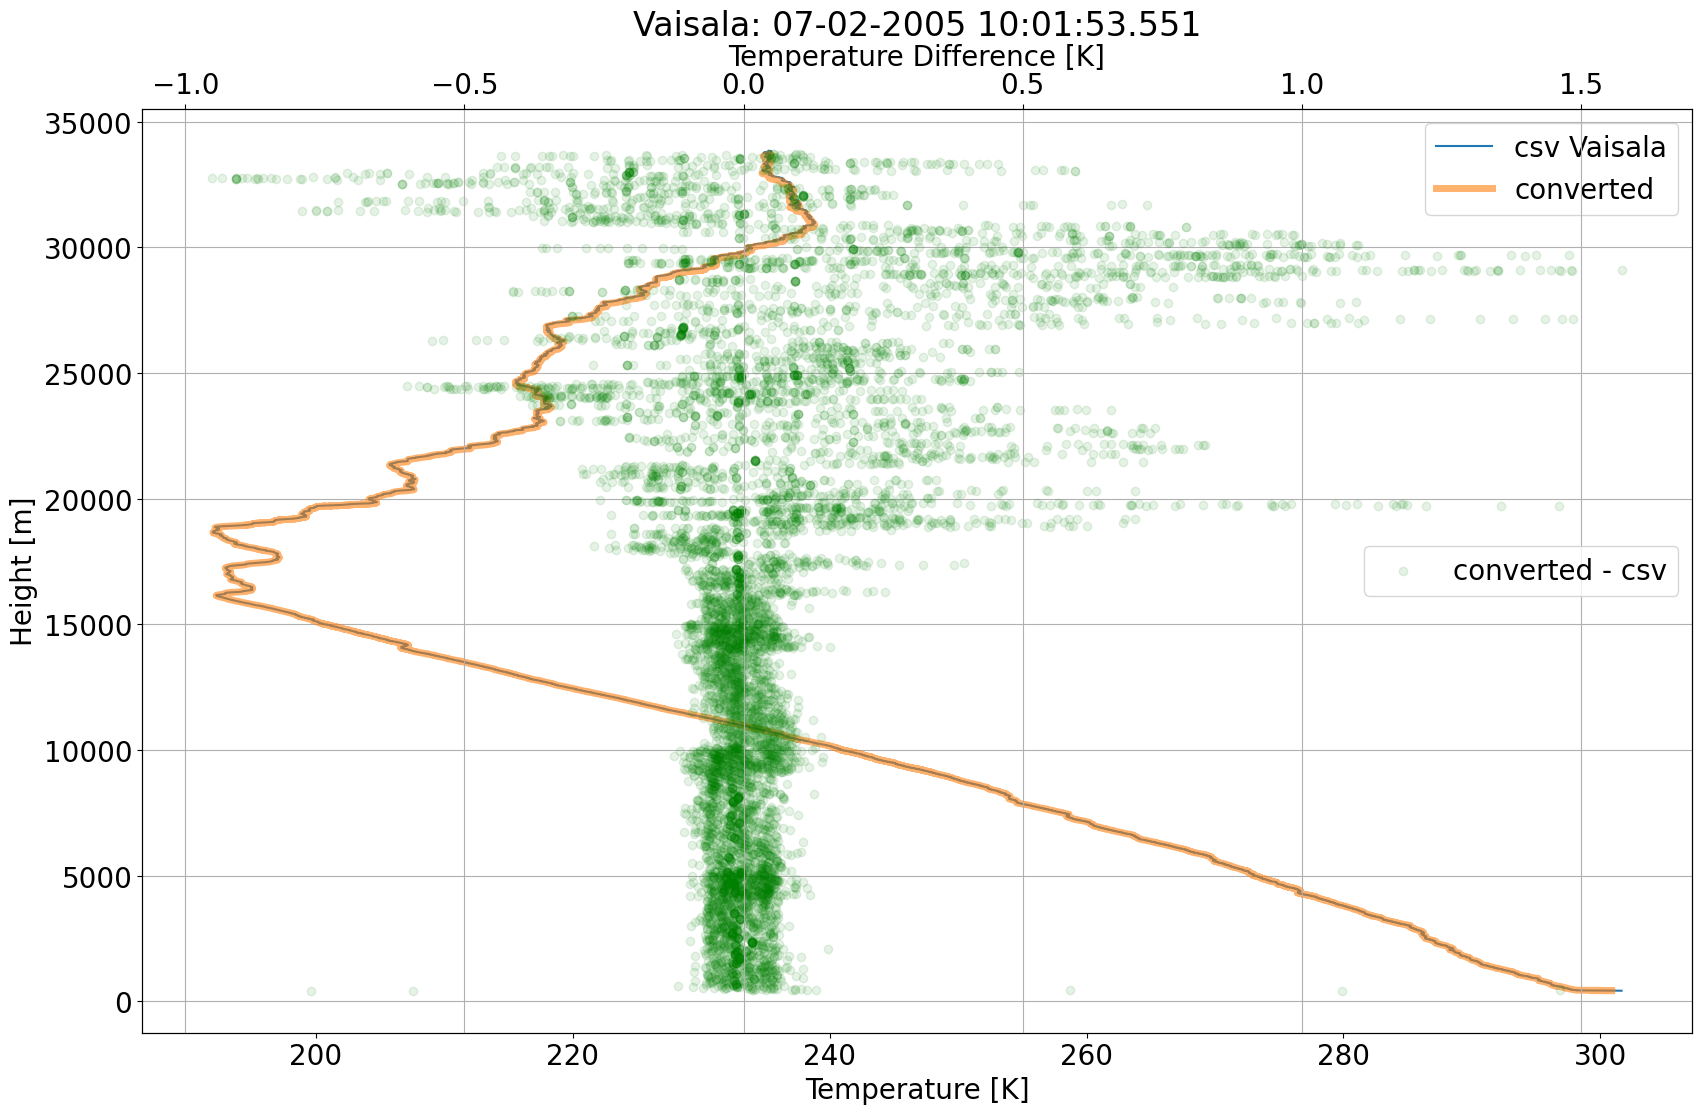

0.060098876345486225


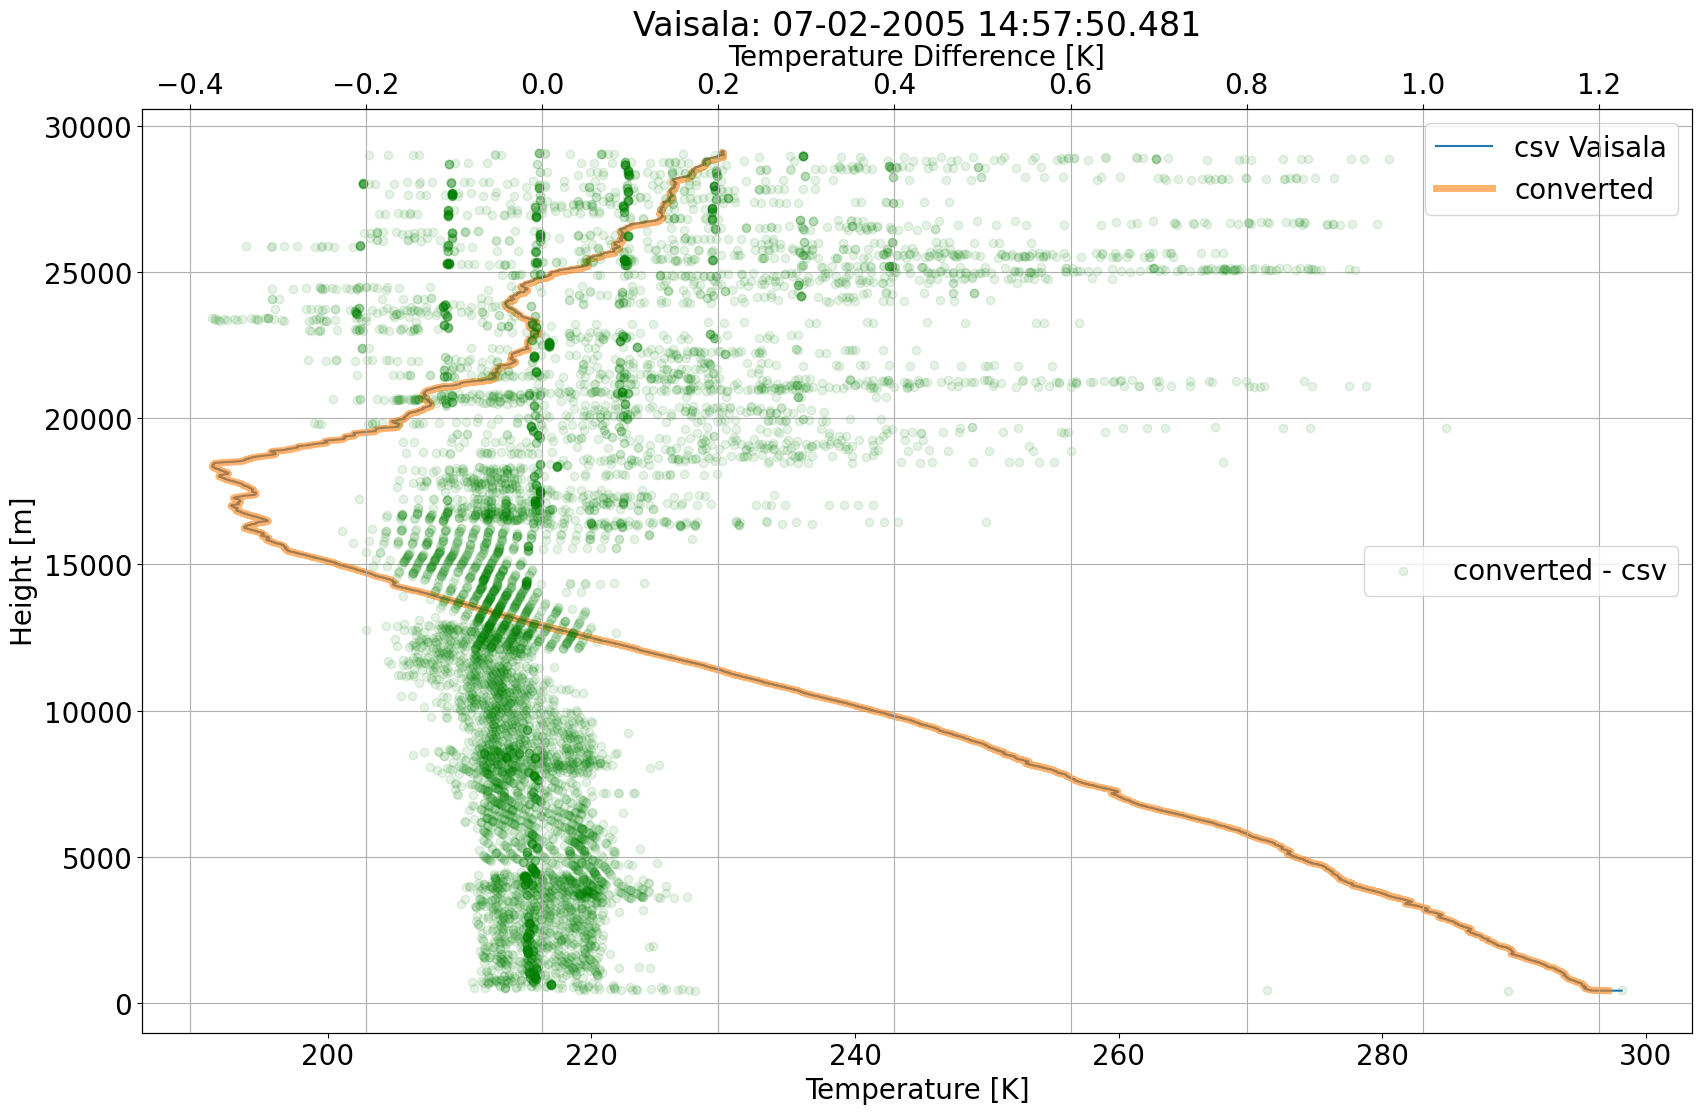

0.04706683403012852


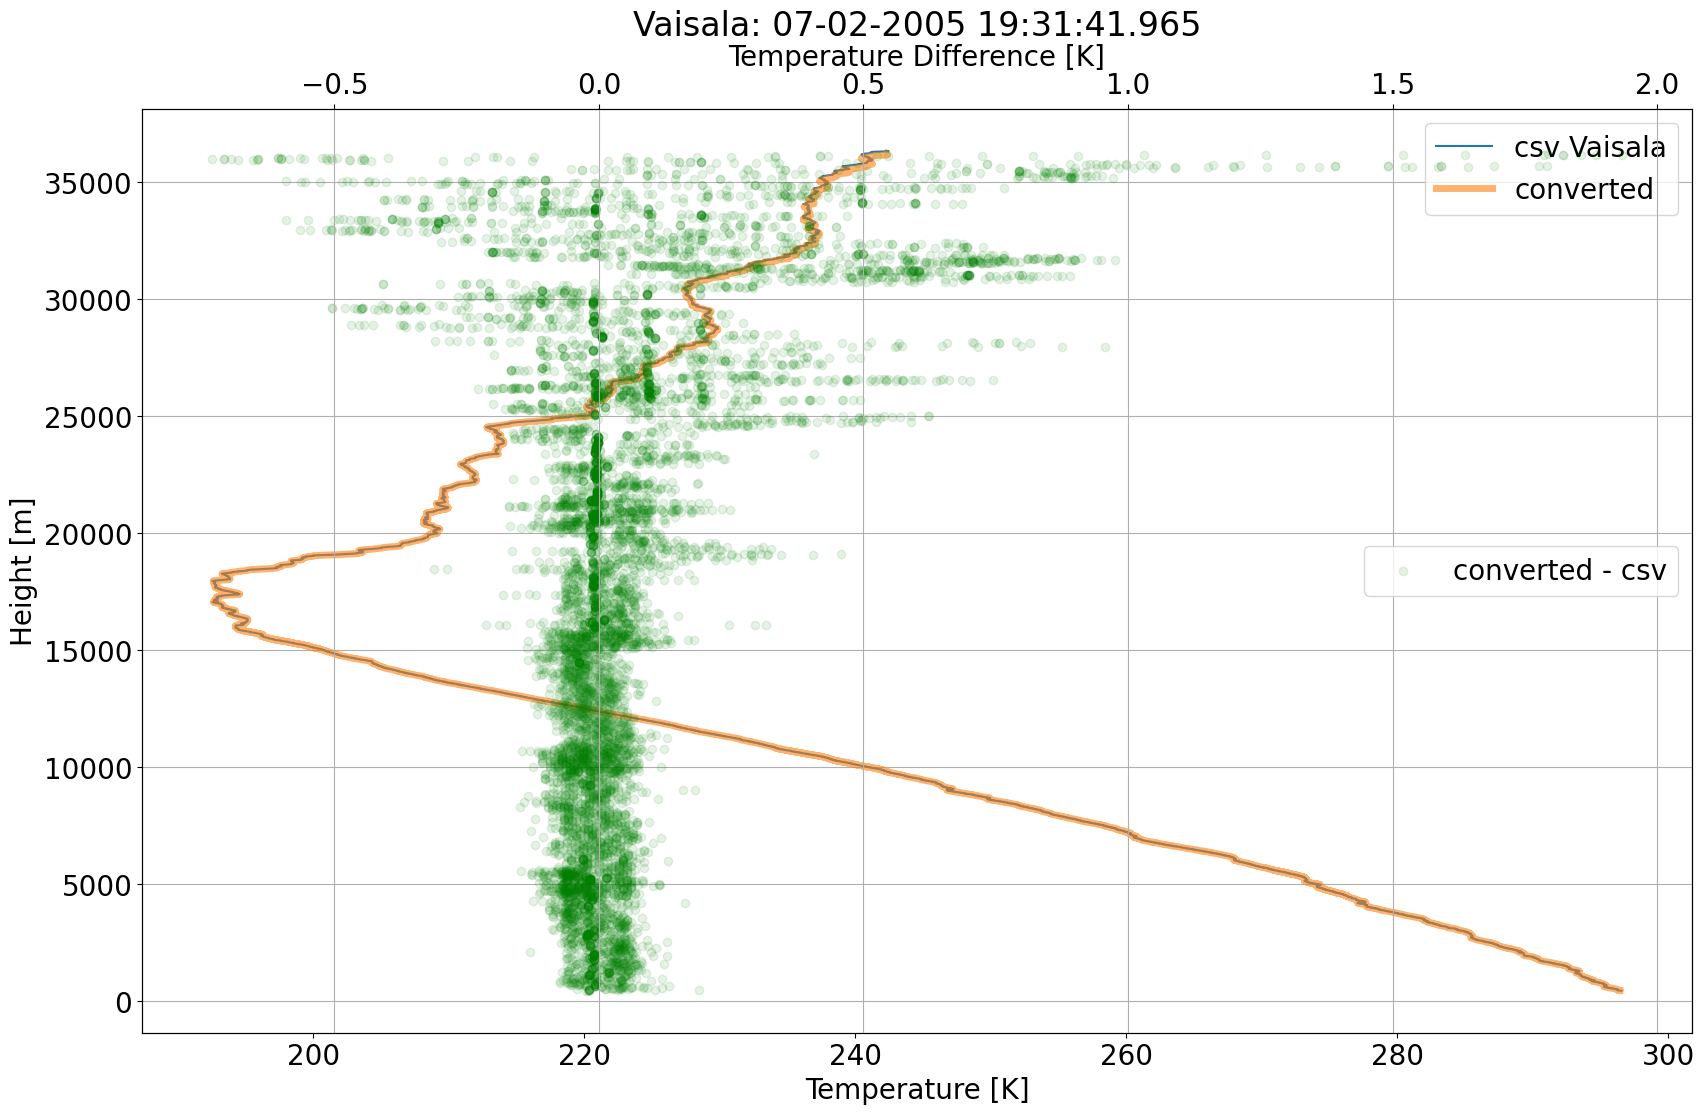

0.058477960504290036


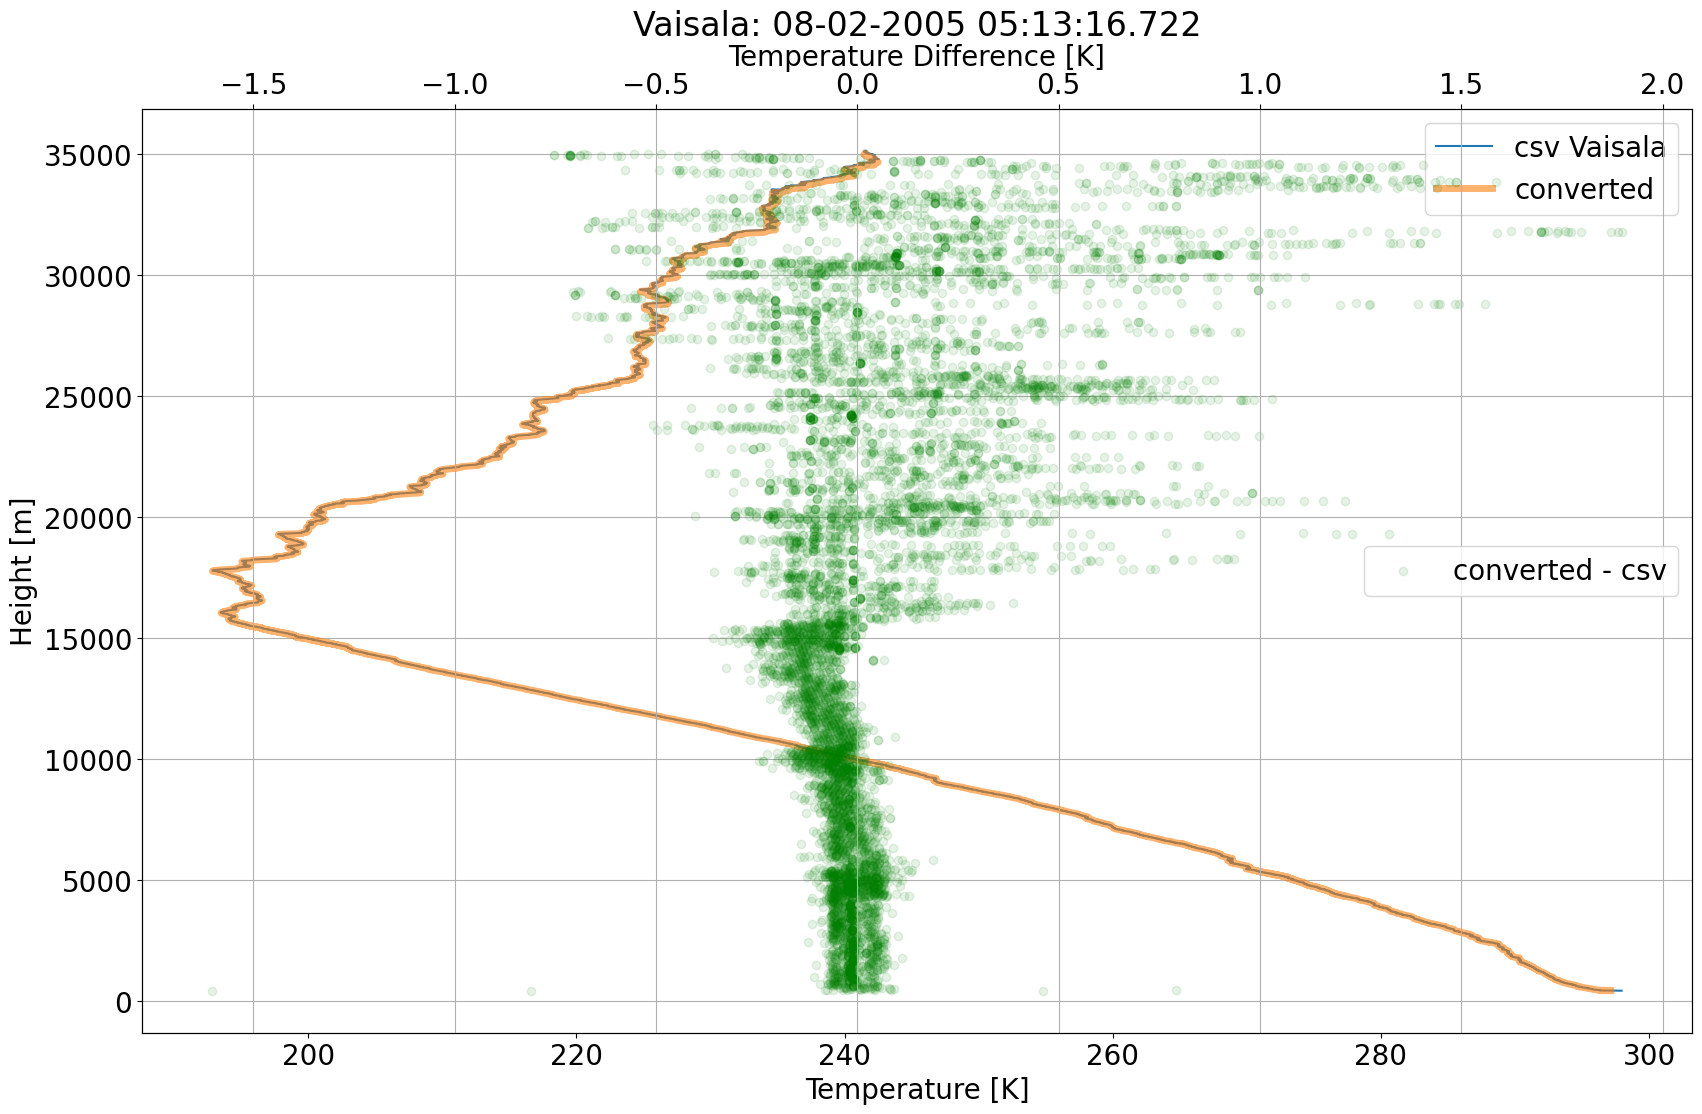

0.06515119500456765


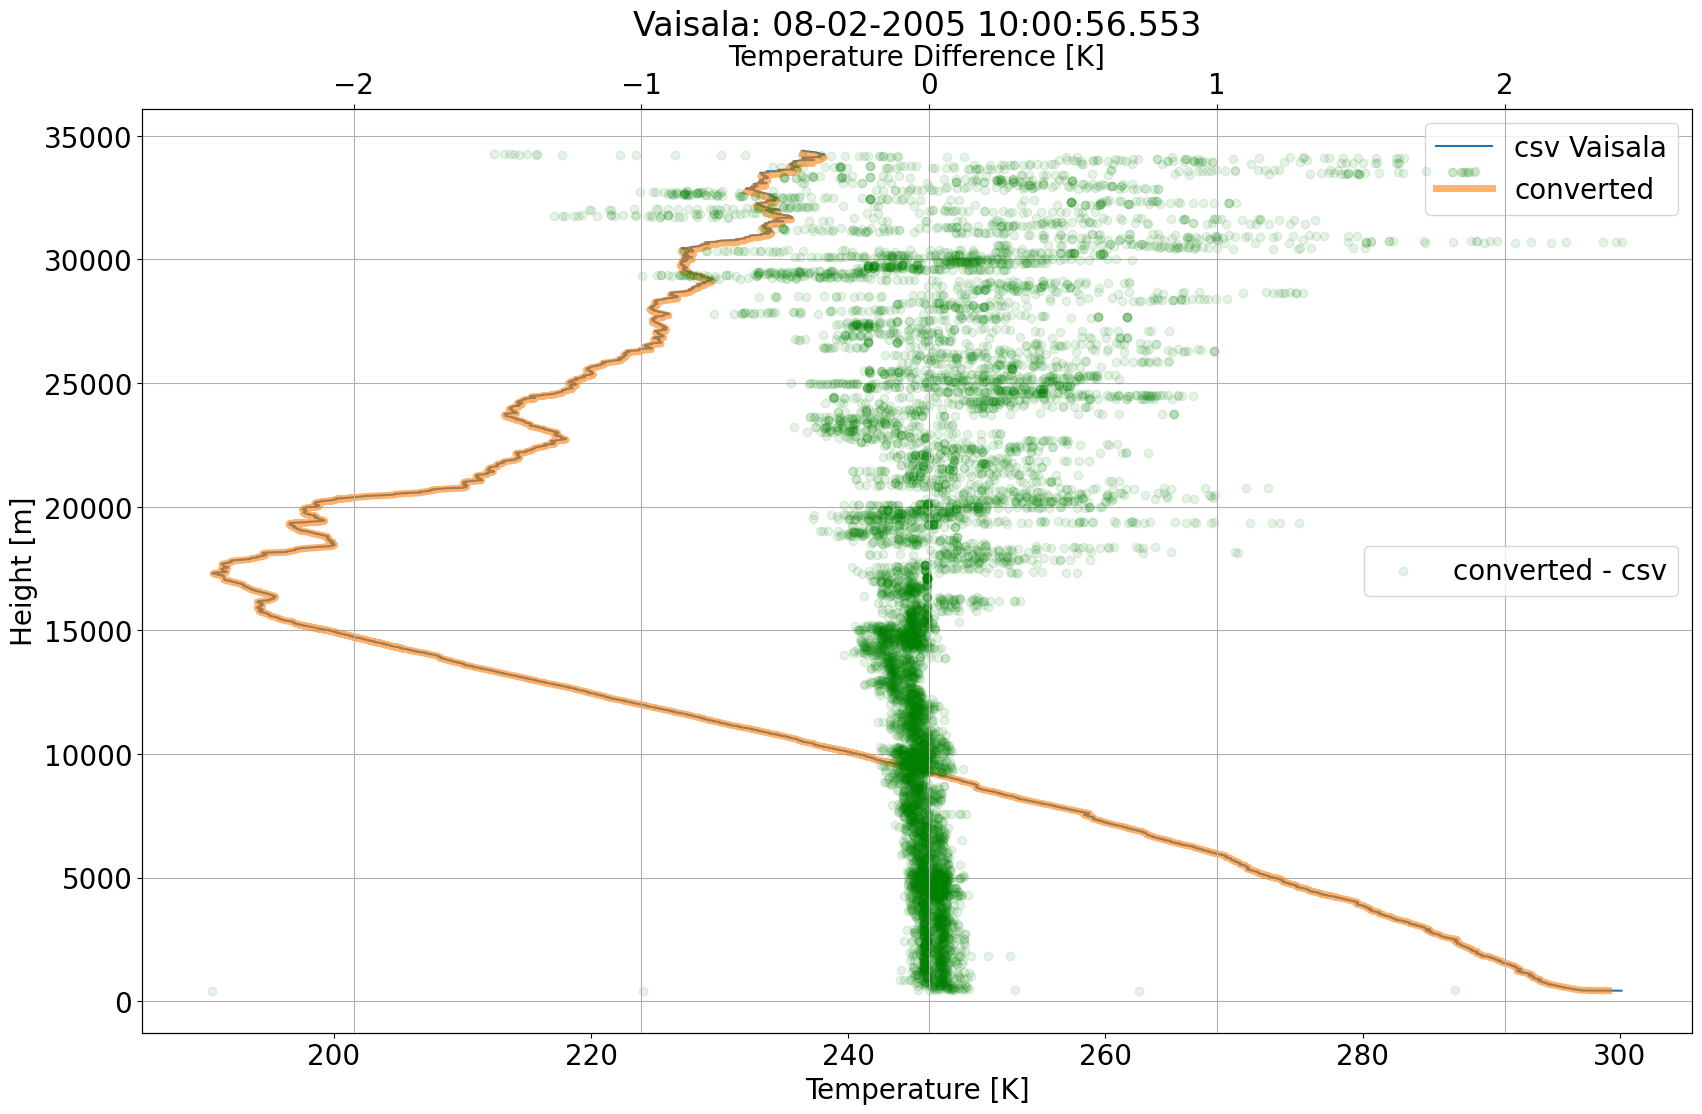

0.04725320500654885


In [206]:
matplotlib.rcParams["figure.figsize"] = (20, 12)
ascs = asc_list[:] #['07-02-2005 10:01:53.551', '07-02-2005 14:57:50.481', '07-02-2005 19:31:41.965']
o = 315
for i in range(len(ascs[:5])):
    vais_df = pd.read_csv('./vaisala_ascents.csv')
    vais_df = vais_df[vais_df.date_time == ascs[i]]
    vais_df = vais_df[vais_df.height > 0]
    vais_df.temperature = vais_df.temperature + 273.15
    plt.plot(vais_df.temperature, vais_df.height, label='csv Vaisala')#, alpha = 0.4, linewidth = 6)

    diff = []
    diff_y = []
    to_merge = []
    for j in glob.glob('./out_height_zoomed/Vaisala_'+str(i+1)+'_*_.csv'):
        to_merge.append(pd.read_csv(j, usecols=['press', 'temp']))
        
    whole_df = pd.concat(to_merge, join='outer', ).sort_values(by='press', ascending=True)
    
    whole_df['adjust'] = np.array( [1] * len(whole_df.press) )
    whole_df.loc[whole_df['press'] < 12000, ['adjust']] = 1
    
    plt.plot(whole_df.temp, whole_df.press * whole_df.adjust, alpha = 0.6, linewidth = 5, label='converted')
    
    diff_interm = []
    for lev_p, lev_t in zip(whole_df.press * whole_df.adjust, whole_df.temp):
        diff_interm.append(lev_t - find_nearest(np.array(vais_df.height), lev_p, np.array(vais_df.temperature)))
    diff_y.extend(whole_df.press)
    diff.extend(diff_interm)
    plt.legend()
    plt.title('Vaisala: ' + ascs[i])
    ax = plt.gca()
    ax.grid(axis='y')
    ax.set_xlabel('Temperature [K]')
    ax.set_ylabel('Height [m]')
    # ax.set_yscale('log')
    # ax.set_ylim(ax.get_ylim()[::-1])

    ax2= ax.twiny()
    ax2.set_xlabel('Temperature Difference [K]')
    ax2.grid()
    # diff = []
    # for lev_p, lev_t in zip(df.press, df.temp):
    #     diff.append(lev_t - find_nearest(np.array(vais_df.height), lev_p, np.array(vais_df.temperature)))
    ax2.scatter(diff, diff_y, color='green', alpha = 0.1, label = 'converted - csv')
    ax2.legend(loc='center right')
    plt.show()
    plt.close()
    print(np.mean(diff))

In [207]:
# matplotlib.rcParams["figure.figsize"] = (20, 12)
# ascs = asc_list[:1] #['07-02-2005 10:01:53.551', '07-02-2005 14:57:50.481', '07-02-2005 19:31:41.965']
# for pltsection in range(0,7,1):
#     adjuster = []
#     mean = []

#     for o in range(0, 350, 1):
#         for i in range(len(ascs)):
#             vais_df = pd.read_csv('./vaisala_ascents.csv')
#             vais_df = vais_df[vais_df.date_time == ascs[i]]
#             vais_df = vais_df[vais_df.height > 0]
#             vais_df.temperature = vais_df.temperature + 273.15
#             # plt.plot(vais_df.temperature, vais_df.height, label='csv Vaisala')#, alpha = 0.4, linewidth = 6)

#             diff = []
#             diff_y = []
#             for j in glob.glob('./out_height_zoomed/Vaisala_'+str(i+1)+'_'+str(pltsection)+'_.csv')[:]:
#                 df = pd.read_csv(j)
#                 # plt.plot(df.temp, df.press + o/100000*df.press, alpha = 0.6, linewidth = 5, label='converted')
#                 diff_interm = []
#                 for lev_p, lev_t in zip(df.press + o/100000*df.press, df.temp):
#                     diff_interm.append(lev_t - find_nearest(np.array(vais_df.height), lev_p, np.array(vais_df.temperature)))
#                 diff_y.extend(df.press)
#                 diff.extend(diff_interm)
#     #         plt.legend()
#     #         plt.title('Vaisala: ' + ascs[i])
#     #         ax = plt.gca()
#     #         ax.set_xlabel('Temperature [K]')
#     #         ax.set_ylabel('Height [m]')
#     #         # ax.set_yscale('log')
#     #         # ax.set_ylim(ax.get_ylim()[::-1])

#     #         ax2= ax.twiny()
#     #         ax2.set_xlabel('Temperature Difference [K]')
#     #         ax2.grid()
#     #         # diff = []
#     #         # for lev_p, lev_t in zip(df.press, df.temp):
#     #         #     diff.append(lev_t - find_nearest(np.array(vais_df.height), lev_p, np.array(vais_df.temperature)))
#     #         ax2.scatter(diff, diff_y, color='green', alpha = 0.1, label = 'converted - csv')
#     #         ax2.legend(loc='center right')
#     #         plt.show()
#     #         plt.close()
#             # print(np.mean(diff))
#             adjuster.append(o)
#             mean.append(np.sum(np.abs(diff)))
#     pointer = np.argmin(mean)
#     print(pltsection, adjuster[pointer])


In [208]:
# adjuster_dict = {
#     0: 315,
#     1: 239,
#     2: 156,
#     3: 65,
#     4: 7,
#     5: 20,
#     6: 16,
# }

In [209]:
# adjuster_dict

In [210]:
# matplotlib.rcParams["figure.figsize"] = (20, 12)
# ascs = asc_list[:] #['07-02-2005 10:01:53.551', '07-02-2005 14:57:50.481', '07-02-2005 19:31:41.965']
# o = 315
# for i in range(len(ascs[:10])):
#     vais_df = pd.read_csv('./vaisala_ascents.csv')
#     vais_df = vais_df[vais_df.date_time == ascs[i]]
#     vais_df = vais_df[vais_df.height > 0]
#     vais_df.temperature = vais_df.temperature + 273.15
#     plt.plot(vais_df.temperature, vais_df.height, label='csv Vaisala')#, alpha = 0.4, linewidth = 6)

#     diff = []
#     diff_y = []
#     for j in glob.glob('./out_height_zoomed/Vaisala_'+str(i+1)+'_*_.csv'): #+glob.glob('./out_height_zoomed/Vaisala_'+str(i+1)+'_4_.csv')+glob.glob('./out_height_zoomed/Vaisala_'+str(i+1)+'_5_.csv'):
#         df = pd.read_csv(j)
#         level = int(j.split('_.csv')[0][-1])
#         if level <= 6:
#             o = adjuster_dict[level]
#             df['adjust'] = np.array( [(1 + o/100000)] * len(df.press) )
#             df.loc[df['press'] < 12000, ['adjust']] = 1
#         else:
#              df['adjust'] = np.array( [1] * len(df.press) )
#         plt.plot(df.temp, df.press * df.adjust, alpha = 0.6, linewidth = 5, label='converted')
#         diff_interm = []
#         for lev_p, lev_t in zip(df.press * df.adjust, df.temp):
#             diff_interm.append(lev_t - find_nearest(np.array(vais_df.height), lev_p, np.array(vais_df.temperature)))
#         diff_y.extend(df.press)
#         diff.extend(diff_interm)
#     plt.legend()
#     plt.title('Vaisala: ' + ascs[i])
#     ax = plt.gca()
#     ax.grid(axis='y')
#     ax.set_xlabel('Temperature [K]')
#     ax.set_ylabel('Height [m]')
#     # ax.set_yscale('log')
#     # ax.set_ylim(ax.get_ylim()[::-1])

#     ax2= ax.twiny()
#     ax2.set_xlabel('Temperature Difference [K]')
#     ax2.grid()
#     # diff = []
#     # for lev_p, lev_t in zip(df.press, df.temp):
#     #     diff.append(lev_t - find_nearest(np.array(vais_df.height), lev_p, np.array(vais_df.temperature)))
#     ax2.scatter(diff, diff_y, color='green', alpha = 0.1, label = 'converted - csv')
#     ax2.legend(loc='center right')
#     plt.show()
#     plt.close()
#     print(np.mean(diff))


# Temperature difference just due to height calc:

In [211]:
# def calc_height(t, p):
#     '''
#     t
    
#     isotherm height formula
#     z = -R*t0/g * ln(p/p0)
#     z = -287.053*t0/9.80665 * ln(p/p0)
    
#     polytrop height forumula
#     z = t0/L * ((p/p0)**(-L*R/g) -1)
#     L = −0.0065 K/m
#     R = 287.053 J/(kg K)
#     g = 9.80665 m/s2
#     z = t0/−0.0065 * ((p/p0)**(0.0065*287.053/9.80665) -1)
    
#     international height formula
#     z = 288.15/0.0065 * (1- (p/1013.25)**(1/5.255))
    
#     '''
#     # from: https://www.cesm.ucar.edu/models/cesm1.1/cesm/cesmBbrowser/html_code/cam/tropopause.F90.html
#     # https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2003GL018240
    
#     SHR_CONST_AVOGAD  = 6.02214e26
#     SHR_CONST_BOLTZ   = 1.38065e-23
#     SHR_CONST_MWDAIR  = 28.966
#     SHR_CONST_RGAS    = SHR_CONST_AVOGAD*SHR_CONST_BOLTZ
#     SHR_CONST_RDAIR   = SHR_CONST_RGAS/SHR_CONST_MWDAIR
#     rair = SHR_CONST_RDAIR

#     SHR_CONST_G       = 9.80616
#     gravit = SHR_CONST_G

#     SHR_CONST_CPDAIR  = 1.00464e3
#     cappa        = (SHR_CONST_RGAS/SHR_CONST_MWDAIR)/SHR_CONST_CPDAIR
#     cnst_kap = cappa

#     cnst_faktor = -gravit/rair
#     cnst_ka1    = cnst_kap - 1.
        
#     z = []
#     for i in range(len(t)):
        
#         if i == 0:
#             L = -0.0065
#             height = t[i]/L * ((p[i]/101325)**(-L*287.053/9.80665) -1)
#             z.append(height)
#         else:
                   
#             # dt/dz
#             pmk= .5 * (p[i-1]**cnst_kap+p[i]**cnst_kap)
#             pm = pmk**(1/cnst_kap)               
#             a = (t[i-1]-t[i])/(p[i-1]**cnst_kap-p[i]**cnst_kap)
#             b = t[i]-(a*p[i]**cnst_kap)
#             tm = a * pmk + b               
#             dtdp = a * cnst_kap * (pm**cnst_ka1)
#             L = cnst_faktor*dtdp*pm/tm # dtdz
#             if L == 0:
#                 L = -0.001

#             height = t[i-1]/L * ((p[i]/p[i-1])**(-L*287.053/9.80665) -1)
#             if np.isnan(height):
#                 z.append(z[-1])
#             else:
#                 z.append(z[-1] + height)
#     return z

In [212]:
# matplotlib.rcParams["figure.figsize"] = (20, 12)
# ascs = asc_list[:] #['07-02-2005 10:01:53.551', '07-02-2005 14:57:50.481', '07-02-2005 19:31:41.965']
# o = 315
# for i in range(len(ascs[:1])):
#     diff_interm = []
#     vais_df = pd.read_csv('./vaisala_ascents.csv')
#     vais_df = vais_df[vais_df.date_time == ascs[i]]
#     vais_df = vais_df[vais_df.height > 0]
#     vais_df.temperature = vais_df.temperature + 273.15
#     vais_df.height_calc = calc_height(np.array(vais_df.temperature), np.array(vais_df.pressure*100))
#     plt.plot(vais_df.temperature, vais_df.height, label='csv Vaisala')#, alpha = 0.4, linewidth = 6)
#     plt.plot(vais_df.temperature, vais_df.height_calc, label='csv Vaisala calculated')#, alpha = 0.4, linewidth = 6)
    
#     for lev_p, lev_t in zip(vais_df.height_calc, vais_df.temperature):
#         diff_interm.append(lev_t - find_nearest(np.array(vais_df.height), lev_p, np.array(vais_df.temperature)))
#     diff_y = vais_df.height
#     diff = diff_interm
#     plt.legend()
#     plt.title('Vaisala: ' + ascs[i])
#     ax = plt.gca()
#     ax.grid(axis='y')
#     ax.set_xlabel('Temperature [K]')
#     ax.set_ylabel('Height [m]')
#     # ax.set_yscale('log')
#     # ax.set_ylim(ax.get_ylim()[::-1])

#     ax2= ax.twiny()
#     ax2.set_xlabel('Temperature Difference [K]')
#     ax2.grid()
#     ax2.scatter(diff, diff_y, color='green', alpha = 0.1, label = 'converted - csv')
#     ax2.legend(loc='center right')
#     plt.show()
#     plt.close()
#     print(np.mean(diff))


In [213]:
# matplotlib.rcParams["figure.figsize"] = (20, 12)
# ascs = asc_list[:3] #['07-02-2005 10:01:53.551', '07-02-2005 14:57:50.481', '07-02-2005 19:31:41.965']
# for i in range(len(ascs)):
#     vais_df = pd.read_csv('./vaisala_ascents.csv')
#     vais_df = vais_df[vais_df.date_time == ascs[i]]
#     vais_df = vais_df[vais_df.height > 0]
#     vais_df.temperature = vais_df.temperature + 273.15
#     plt.plot(vais_df.temperature, vais_df.height, label='csv Vaisala')#, alpha = 0.4, linewidth = 6)
    
#     diff = []
#     diff_y = []
#     for j in glob.glob('./out_height_zoomed/Vaisala_'+str(i+1)+'_*_.csv')[:]:
#         df = pd.read_csv(j)
#         plt.plot(df.temp, df.press, alpha = 0.6, linewidth = 5, label='converted')
#         diff_interm = []
#         for lev_p, lev_t in zip(df.press, df.temp):
#             diff_interm.append(lev_t - find_nearest(np.array(vais_df.height), lev_p, np.array(vais_df.temperature)))
#         diff_y.extend(df.press)
#         diff.extend(diff_interm)
#     plt.legend()
#     plt.title('Vaisala: ' + ascs[i])
#     ax = plt.gca()
#     ax.set_xlabel('Temperature [K]')
#     ax.set_ylabel('Height [m]')
#     # ax.set_yscale('log')
#     # ax.set_ylim(ax.get_ylim()[::-1])
    
#     ax2= ax.twiny()
#     ax2.set_xlabel('Temperature Difference [K]')
#     ax2.grid()
#     # diff = []
#     # for lev_p, lev_t in zip(df.press, df.temp):
#     #     diff.append(lev_t - find_nearest(np.array(vais_df.height), lev_p, np.array(vais_df.temperature)))
#     ax2.scatter(diff, diff_y, color='green', alpha = 0.1, label = 'converted - csv')
#     ax2.legend(loc='center right')
#     plt.show()
#     plt.close()
#     print(np.mean(diff))
